# Lung Segmentation

Machine learning can help diagnose disease from medical images such as X-Rays and CT scans. One example of this is diagnosing pneumonia or pneumothorax from chest scans. 

Now such tasks might be easier if we know exactly where the lung is in the image! That's where **lung segmentation** comes into play. 

In this notebook we'll explore a new application of neural networks called **segmentation**. Segmentation is the task of identifying regions of interest in an image. We'll:



*   Understand a dataset of *images* and *masks*
*   Try a relatively simple CNN model, and understand why it fails
*   Explore a different loss function, Dice, to improve our model
*   (Optional) Try a special segmentation architecture, U-Nets



 Let's check it out! 

In [ ]:
#@title Run to load data and helper functions
import matplotlib.pyplot as plt
import os
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, concatenate, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
import gdown
from ipywidgets import interact, IntSlider

IMG_PATH = "reduced/imgs"
MASK_PATH = "reduced/masks"
EPOCHS = 40

gdown.download("https://drive.google.com/uc?id=1_2UHVdkeuCHwwcb2RGs0cosNw8l_YoAE", "reduced.zip", True)
!unzip -oq reduced.zip

np.random.seed(12)
tf.random.set_seed(12)

def load():
    imgs_paths = sorted([Path(IMG_PATH) / p for p in os.listdir(IMG_PATH)])
    masks_paths = sorted([Path(MASK_PATH) / p for p in os.listdir(MASK_PATH)])
    imgs = [plt.imread(p) for p in imgs_paths]
    masks = [plt.imread(p)[:, :, 0][:, :, None] > 0.5 for p in masks_paths]
    imgs, masks = np.array(imgs)[:,:,:,0:1], np.array(masks).astype(float)
    imgs_train, imgs_test, masks_train, masks_test = train_test_split(
        imgs, masks, test_size=0.2, shuffle=False
    )
    return imgs_train, imgs_test, masks_train, masks_test

def show_lung_mask_sbs(lung, mask):
    fig, (a1, a2) = plt.subplots(1, 2)
    a1.imshow(lung.squeeze(), cmap = 'gray')
    a2.imshow(mask.squeeze(), cmap = 'gray')
    a1.set_title("lung")
    a2.set_title("mask")


def show_lung_mask_pred_sbs(lung, mask, pred):
    fig, (a1, a2, a3) = plt.subplots(1, 3)
    a1.imshow(lung.squeeze(), cmap = 'gray')
    a2.imshow(mask.squeeze(), cmap = 'gray')
    a3.imshow(pred.squeeze(), cmap = 'gray')
    a1.set_title("lung")
    a2.set_title("mask")
    a3.set_title("predicted mask")

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return 1 - numerator / denominator

class ShowLearning(tf.keras.callbacks.Callback):
    def __init__(self, data, masks, name):
        self.data = data
        self.masks = masks
        self.fig_path = f"lung/figs/{name}"
        if not os.path.exists(self.fig_path):
            os.makedirs(self.fig_path)
        super().__init__()

    def on_epoch_begin(self, epoch, logs=None):
        rand_index = np.random.randint(0, len(self.data))
        rand_img = self.data[rand_index][None, :, :, :]
        mask = self.masks[rand_index][None, :, :, :]
        preds = self.model(rand_img).numpy() > 0.5
        show_lung_mask_pred_sbs(rand_img, mask, preds)
        plt.savefig(f"{self.fig_path}/epoch{epoch}.png")
        plt.close()

def show_training_image(name, epoch):
  im = plt.imread(f'lung/figs/{name}/epoch{epoch}.png')
  plt.imshow(im)

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return 1 - numerator / denominator


#Exploring our Data

Let's start by loading in the data and checking out the shapes!

We have lung images as well as their masks, which represent where in the image the lungs are located.

In [ ]:
imgs_train, imgs_test, masks_train, masks_test = load()
print(imgs_train.shape, imgs_test.shape, masks_train.shape, masks_test.shape)

(213, 64, 64, 1) (54, 64, 64, 1) (213, 64, 64, 1) (54, 64, 64, 1)


**Discuss:** Can you explain the shape of each dataset?

## Visualizing our data

This is what the data looks like:

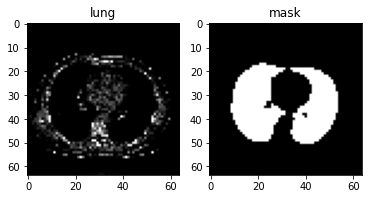

In [ ]:
img_num = 20
show_lung_mask_sbs(imgs_train[img_num], masks_train[img_num])

**Question**: What are we trying to get our model trying to predict here? What are the inputs and outputs of the model?

**Exercise:** Use the code above and a for loop to look through the first 5 images.

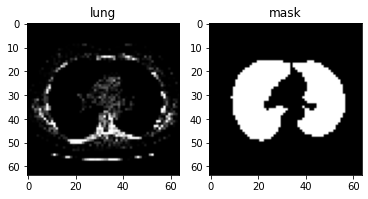

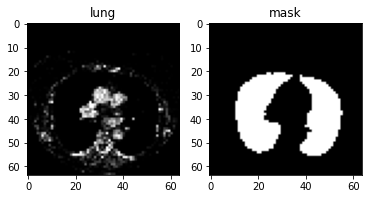

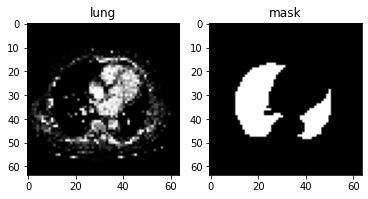

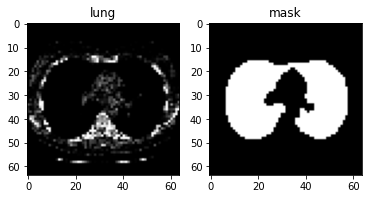

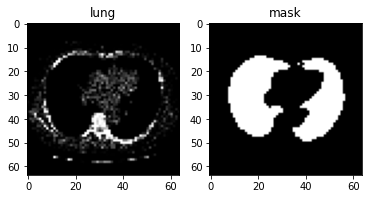

In [ ]:
#YOUR CODE HERE
start_index = __import__("random").randint(0, imgs_train.shape[0] - 5)
for i in range(start_index, start_index+5):
  show_lung_mask_sbs(imgs_train[i], masks_train[i])

# Convolutional Neural Networks

We'll start off with a simple convolutional neural network which is typically great for image processing, and see how it does. Note that this is the same as convolutional neural networks we have seen previously but instead of having one output which is the classification, it does a **binary classification on each pixel!** 

In particular, for each pixel, the model will have a prediction of whether or not that pixel is part of the lung.

## Exercise

Add several Conv2D layers to the Sequential Model. To do this just add several calls to 

`Conv2D(filters = num_filters, kernel_size = kernel_size, strides = 1, padding='same', activation='relu')`

For the num_filters parameter try any combination of 16 and 32, and for the kernel_size parameter use 3! 

We use a stride of `1` and padding of `same` to keep the output's height and width the same after each layer.

**Question:** Why does the final layer have just 1 filter?

In [ ]:
def SimpleConvModel():
    model = tf.keras.models.Sequential(
        [
            #### YOUR CODE HERE to add layers #########
            Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu"),
            Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"),
            Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu"),
            Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu"),
            Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"),
            
            ##### END CODE ########
            Conv2D(filters = 1, kernel_size = 3, strides = 1, padding="same", activation="sigmoid")
        ]
    ) 
    return model

model = SimpleConvModel()

Run the next cell to train the model for 40 epochs. While it trains, follow the values of the loss and the accuracy.


In [ ]:
def train(model, imgs, masks, loss, name, epochs):
    optimizer = tf.optimizers.Adam(learning_rate=0.0003)
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    model.fit(imgs, masks, epochs=epochs, callbacks=[ShowLearning(imgs, masks, name)],)

train(model, imgs_train, masks_train, tf.losses.BinaryCrossentropy(), 'simple_conv', EPOCHS)

Epoch 1/40
7/7 [==============================] - 30s 82ms/step - loss: 0.6923 - accuracy: 0.6469
Epoch 2/40
7/7 [==============================] - 0s 29ms/step - loss: 0.6872 - accuracy: 0.7660
Epoch 3/40
7/7 [==============================] - 0s 29ms/step - loss: 0.6778 - accuracy: 0.7662
Epoch 4/40
7/7 [==============================] - 0s 27ms/step - loss: 0.6590 - accuracy: 0.7662
Epoch 5/40
7/7 [==============================] - 0s 27ms/step - loss: 0.6237 - accuracy: 0.7662
Epoch 6/40
7/7 [==============================] - 0s 28ms/step - loss: 0.5755 - accuracy: 0.7662
Epoch 7/40
7/7 [==============================] - 0s 28ms/step - loss: 0.5620 - accuracy: 0.7662
Epoch 8/40
7/7 [==============================] - 0s 27ms/step - loss: 0.5555 - accuracy: 0.7662
Epoch 9/40
7/7 [==============================] - 0s 29ms/step - loss: 0.5506 - accuracy: 0.7662
Epoch 10/40
7/7 [==============================] - 0s 27ms/step - loss: 0.5461 - accuracy: 0.7662
Epoch 11/40
7/7 [===========

### Predicting Model Output Size
**Discuss: What should the output size of our model be? Why?**

Check your prediction below! We can also visualize the structure of our model.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        4624      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 1)         289       
Total params: 16,673
Trainable params: 16,673
Non-trainable params: 0
____________________________________________________

Our model probably achieved **> 80% accuracy** - not bad!!

Or is it? Let's take a look at some of the predictions. You'll see that our model got better over time - but how much better?




In [ ]:
interact(lambda epoch: show_training_image('simple_conv', epoch), epoch=(0, EPOCHS-1));

interactive(children=(IntSlider(value=19, description='epoch', max=39), Output()), _dom_classes=('widget-inter…

**Question:** Why is the accuracy so high when the results look so unimpressive? How exactly is accuracy calculated?

## Understanding Model Accuracy
**Exercise:** In the masks, what is the percentage of pixels that are part of the lung?

*Hint:* The pixels that are part of the lung are represented as `1` in `masks_train`, so you can find the total number of lung pixels with  `masks_train.sum()`.

You might also find `masks_train.size` useful!

In [ ]:
#YOUR CODE HERE to find percent of pixels in masks that are part of the lung
percentage = masks_train.sum() / masks_train.size
print(percentage)

0.23375605193661972


**Question:** What accuracy could we get if we just predicted all the pixels were not part of the lung?

**Question:** Why is accuracy not super useful for this segmentation task?

Well, it seems like the model is outputing 'not lung' for most pixels. And because in our images most of the pixels are not part of the lung, the model can get pretty high accuracy by just guessing 'not lung' for each pixel! This is clearly not what we want. 

We can try something to address this. First of all, we'll need to rethink what it means to have a 'good' prediction, as just accuracy is clearly not adequate! We need some way to measure how much overlap there is between the *real* lung masks and our predictions.


#Exploring the Loss Function

##The Dice Coefficient 

Instead of accuracy, we'll use a common metric known as the Dice Coefficient (or Sørensen–Dice if you're feeling fancy), which is calculated as follows:

$$\frac{2*|T \cap P|}{|T| + |P|}$$

![test](https://miro.medium.com/max/429/1*yUd5ckecHjWZf6hGrdlwzA.png) 

**$T$**, in blue, is the set of pixels in the image that are **truly part of the lung.**

**$P$**, in red, is the set of pixels that are **predicted to be part of the lung**.

The numerator is the **overlap of true and predicted**: how many pixels are in both categories?

The denominator is the **sum** of **the number of pixels truly in the lung**, plus **the number of pixels that are predicted to be part of the lung**.

Some intuition: to get a high (good) Dice Coefficient, we need a **large numerator** and a **small denominator**.
* To make the numerator large, there needs to be a lot of overlap between the true and predicted 'lung' pixels. 
* To make the denominator small, there shouldn't be that many pixels that are predicted as 'lung' - otherwise we could "cheat" by predicting everything is part of the lung!

**Question:** What would the Dice Coefficient be if we make a perfect prediction? Why is there a 2 in the numerator?

**Question:** What would the Dice Coefficient be if we predict all 'not lung'?

**Question**: What's another way we could get a Dice Coefficient of 0?



## (Optional, Advanced): Implementing Dice
**Exercise:** Implement a function that returns the Dice coefficient. 

Hint:  `sum(true_mask & predicted_mask`) counts the number of pixels that are in both the true mask and the predicted mask.

In [ ]:
def dice(true_mask, predicted_mask):
    #flatten the data
    true_mask, predicted_mask = true_mask.astype(bool).flatten(), predicted_mask.astype(bool).flatten()
    #YOUR CODE HERE to return the dice coefficient
    calculated = sum(true_mask & predicted_mask) * 2 / (true_mask.sum() + predicted_mask.sum())
    return calculated

Now, let's try out our Dice score - how well do our predictions do? By changing the inputs, can you achieve a Dice score of 0.0 or 1.0?

Dice score: 0.6646294881588999


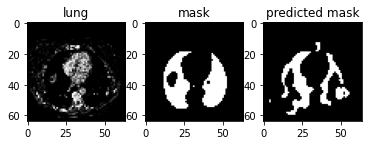

In [ ]:
img_num = __import__("random").randint(0, imgs_train.shape[0]) #Choose any image

img = np.expand_dims(imgs_train[img_num],0)
true_mask = masks_train[img_num]
pred_mask = model.predict(img) > 0.5

show_lung_mask_pred_sbs(img, true_mask, pred_mask)

print("Dice score:", dice(true_mask, pred_mask)) #Try changing the inputs to dice!

In [ ]:
#YOUR CODE HERE to explore changing the inputs (create some arrays!)

## Same model, different loss

To make our model actually *find* the lungs rather than using the "always guess no" trick, we can try changing the loss function. Remember that the **the model tries to minimize the loss function during training**. Now that we care about the Dice Coefficient more than accuracy, we can change our loss function to reflect that.

Note that "Dice Loss" is just 1 - Dice: minimizing Dice Loss is the same thing as maximizing the Dice Coefficient!

In [ ]:
model_with_dice = SimpleConvModel()
train(model_with_dice, imgs_train, masks_train, dice_loss, 'simple_conv_with_dice', EPOCHS)

Epoch 1/40
7/7 [==============================] - 1s 29ms/step - loss: 0.6860 - accuracy: 0.3272
Epoch 2/40
7/7 [==============================] - 0s 28ms/step - loss: 0.6845 - accuracy: 0.2341
Epoch 3/40
7/7 [==============================] - 0s 28ms/step - loss: 0.6813 - accuracy: 0.2338
Epoch 4/40
7/7 [==============================] - 0s 28ms/step - loss: 0.6746 - accuracy: 0.2338
Epoch 5/40
7/7 [==============================] - 1s 28ms/step - loss: 0.6609 - accuracy: 0.2338
Epoch 6/40
7/7 [==============================] - 0s 28ms/step - loss: 0.6399 - accuracy: 0.2338
Epoch 7/40
7/7 [==============================] - 0s 28ms/step - loss: 0.6243 - accuracy: 0.2338
Epoch 8/40
7/7 [==============================] - 0s 28ms/step - loss: 0.6222 - accuracy: 0.2338
Epoch 9/40
7/7 [==============================] - 0s 28ms/step - loss: 0.6228 - accuracy: 0.2338
Epoch 10/40
7/7 [==============================] - 0s 28ms/step - loss: 0.6226 - accuracy: 0.2338
Epoch 11/40
7/7 [============

In [ ]:
interact(lambda epoch: show_training_image('simple_conv_with_dice', epoch), epoch=(0, EPOCHS-1));

interactive(children=(IntSlider(value=19, description='epoch', max=39), Output()), _dom_classes=('widget-inter…

**Question**: Compare the above results to the results from before. Are the predictions any better or more believable than before? What is a new problem that is arising?

# (Optional) Changing Our Model: U-Nets

So even though we have changed our loss to better suit the problem, we can still do better! To do this, we'll use U-Nets, which are a special type of convolutional neural network with a "U shaped" architecture. It works by first compressing and then expanding the image back to full size. 

Compressing the image (on the left side of the U) allows us to create many feature maps. Then - since for segmentation we need to output an image of the same size as the original - we upsample. Importantly, we also copy the original feature maps of a particular size during the compression stage. This greatly reduces distortion, as it is like we have a copy of the original image in the expansion section.

U-Nets are tricky to understand - no worries if you're fuzzy on some of the details! 
![alt text](https://miro.medium.com/max/2824/1*f7YOaE4TWubwaFF7Z1fzNw.png)

We've implemented a small U-Net for you here (**not exactly the diagram**). Check it out and experiment with it if you're interested! You'll notice it has only five "sections" total (two on the way down, one at the bottom, and two on the way up). What does each section consist of?

**Try drawing a diagram for this U-Net!**



In [ ]:
#Check out the U-Net code if you're interested!

def section(conv1_filters, conv2_filters): #Represents one horizontal "section" of the U
    return tf.keras.Sequential(
        [
            Conv2D(conv1_filters, 3, padding="same", activation="relu"),
            Conv2D(conv2_filters, 3, padding="same", activation="relu"),
        ]
    )

class U_Net(tf.keras.Model):
    def __init__(self):
        super(U_Net, self).__init__() #What do the numbers represent? 
        self.section1 = section(16, 16)
        self.section2 = section(32, 32)
        self.section3 = section(32, 64) #Bottom of the U!
        self.section4 = section(32, 32)
        self.section5 = section(16, 16)
        self.final_conv = Conv2D(1, 3, padding="same", activation="sigmoid")
        self.maxpool1, self.maxpool2 = MaxPool2D(2), MaxPool2D(2) #Why are there two of these?
        self.upsample1, self.upsample2 = UpSampling2D(2), UpSampling2D(2)

    def call(self, inputs):
        input1 = self.section1(inputs)
        input2 = self.section2(self.maxpool1(input1))
        input3 = self.section3(self.maxpool2(input2))
        input4 = self.section4(concatenate([input2, self.upsample1(input3)]))
        input5 = self.section5(concatenate([input1, self.upsample2(input4)]))
        output = self.final_conv(input5)
        return output

In [ ]:
unet = U_Net()

Let's use Dice Loss with our U-Net.

As this model trains, look at how the accuracy and loss change. Is the training generally steady or are there certain epochs with breakthroughs?

In [ ]:
train(unet, imgs_train, masks_train, dice_loss, 'unet_with_dice', epochs=EPOCHS)

Epoch 1/40
7/7 [==============================] - 3s 100ms/step - loss: 0.6864 - accuracy: 0.4589
Epoch 2/40
7/7 [==============================] - 1s 41ms/step - loss: 0.6853 - accuracy: 0.3060
Epoch 3/40
7/7 [==============================] - 1s 40ms/step - loss: 0.6796 - accuracy: 0.2393
Epoch 4/40
7/7 [==============================] - 1s 41ms/step - loss: 0.6485 - accuracy: 0.2340
Epoch 5/40
7/7 [==============================] - 1s 39ms/step - loss: 0.6047 - accuracy: 0.2339
Epoch 6/40
7/7 [==============================] - 1s 40ms/step - loss: 0.6028 - accuracy: 0.2396
Epoch 7/40
7/7 [==============================] - 1s 41ms/step - loss: 0.5823 - accuracy: 0.3249
Epoch 8/40
7/7 [==============================] - 1s 40ms/step - loss: 0.5333 - accuracy: 0.5273
Epoch 9/40
7/7 [==============================] - 1s 40ms/step - loss: 0.4597 - accuracy: 0.6969
Epoch 10/40
7/7 [==============================] - 1s 39ms/step - loss: 0.3372 - accuracy: 0.8797
Epoch 11/40
7/7 [===========

In [ ]:
interact(lambda epoch: show_training_image('unet_with_dice', epoch), epoch=(0, EPOCHS-1));

interactive(children=(IntSlider(value=19, description='epoch', max=39), Output()), _dom_classes=('widget-inter…

## Evaluation

Run the next cell to visualize the predictions of the UNet on the test set! As a reminder, our model has never seen this data before. Will it be able to predict somewhat accurate looking masks?

In [ ]:
thresh = 0.5 #Experiment with changing this!
preds = unet(imgs_test).numpy()
preds = preds >= thresh

def show_preds_helper(imgs_test, masks_test, preds, ind):
    show_lung_mask_pred_sbs(imgs_test[ind], masks_test[ind], preds[ind])
    plt.show()

interact(lambda i: show_preds_helper(imgs_test, masks_test, preds, i), i=(0, len(preds)-1));

interactive(children=(IntSlider(value=26, description='i', max=53), Output()), _dom_classes=('widget-interact'…

Pretty darn good :)

## Advanced: Improving Your Model

Keep experimenting with our models to see if you can achieve human-level performance! You can try a few things:


*   Train for more epochs.
*   Try changing the hyperparameters, like learning rate.
*   Experiment with the structure of U-Net: can you change the number of sections, or the sizes of the convolutions within each section?
*   Change the threshold for our prediction. For example, if we see that we're overpredicting lung pixels, we could set our threshold a little higher. Remember that the raw output of our models is a probability value for each pixel on whether or not it is part of the lung!
*   *Advanced Challenge*: try implementing a different loss function, like the [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index) or [pixel-wise cross-entropy loss](https://www.jeremyjordan.me/semantic-segmentation/) (which is the loss function we used in our first model). Check out the `dice_loss` function in the hidden cell at the top for an example of the function's structure.

Work with your group to see if you can create a perfect model!


In [ ]:
#YOUR CODE HERE for further experimentation


## References and Acknowledgements:
* Some of these exercises were inspired by CS271 at Stanford
* [Data](https://www.kaggle.com/kmader/finding-lungs-in-ct-data/data?select=lung_stats.csv)
* [Dice Loss](https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/)
* [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras)

Original Notebook by Harry Sha